## Генерируем данные

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, accuracy_score, roc_curve, precision_score
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

import seaborn as sns

In [2]:
N = 4
M = 946

In [3]:
noise = np.random.randn(M * 2, 2)
noise.shape

#Не изменится от кол-ва облаков :(
sh = 0.38;
#sh = 0
mn = 1;
cloud0 = mn * (noise + np.array([-sh, sh]))
cloud1 = mn * (noise + np.array([sh, sh]))
cloud2 = mn * (noise + np.array([-sh, -sh]))
cloud3 = mn * (noise + np.array([sh, -sh]))

XY = np.vstack([cloud0, cloud1, cloud2, cloud3])
annotations = np.zeros(M * 2 * N, dtype = int)
for i in range(1, N):
    curr = i * M * 2
    annotations[curr : curr + M * 2] = annotations[curr : curr + M * 2] + [i] * M * 2

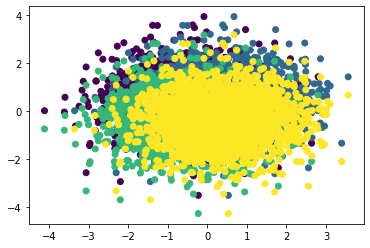

In [4]:
plt.scatter(XY[:,0], XY[:,1], c=annotations)

In [5]:
print(XY.shape)
print(annotations.shape)
data, labels = shuffle(XY, annotations)
test_size = int(len(data) * 0.5)
Xtrain = data[:test_size]
Ytrain = labels[:test_size]
Xtest = data[test_size:]
Ytest = labels[test_size:]

(7568, 2)
(7568,)


In [6]:
clf = LogisticRegression()
clf.fit(Xtrain, Ytrain);
predictions = clf.predict(Xtest)

/opt/conda/envs/jupyter_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/jupyter_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [7]:
print(confusion_matrix(Ytest, predictions))
print(accuracy_score(Ytest, predictions))

[[407 233 199 102]
 [215 420  98 178]
 [225 147 385 201]
 [118 262 233 361]]
0.41569767441860467


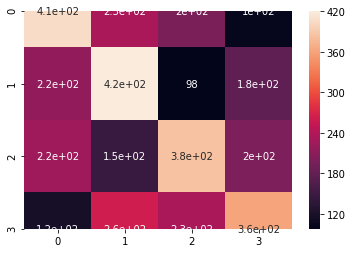

In [8]:
conf_mat = confusion_matrix(Ytest, predictions)
sns.heatmap(conf_mat, annot=True)

In [9]:
report = classification_report(Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.42      0.43      0.43       941
           1       0.40      0.46      0.43       911
           2       0.42      0.40      0.41       958
           3       0.43      0.37      0.40       974

    accuracy                           0.42      3784
   macro avg       0.42      0.42      0.42      3784
weighted avg       0.42      0.42      0.42      3784



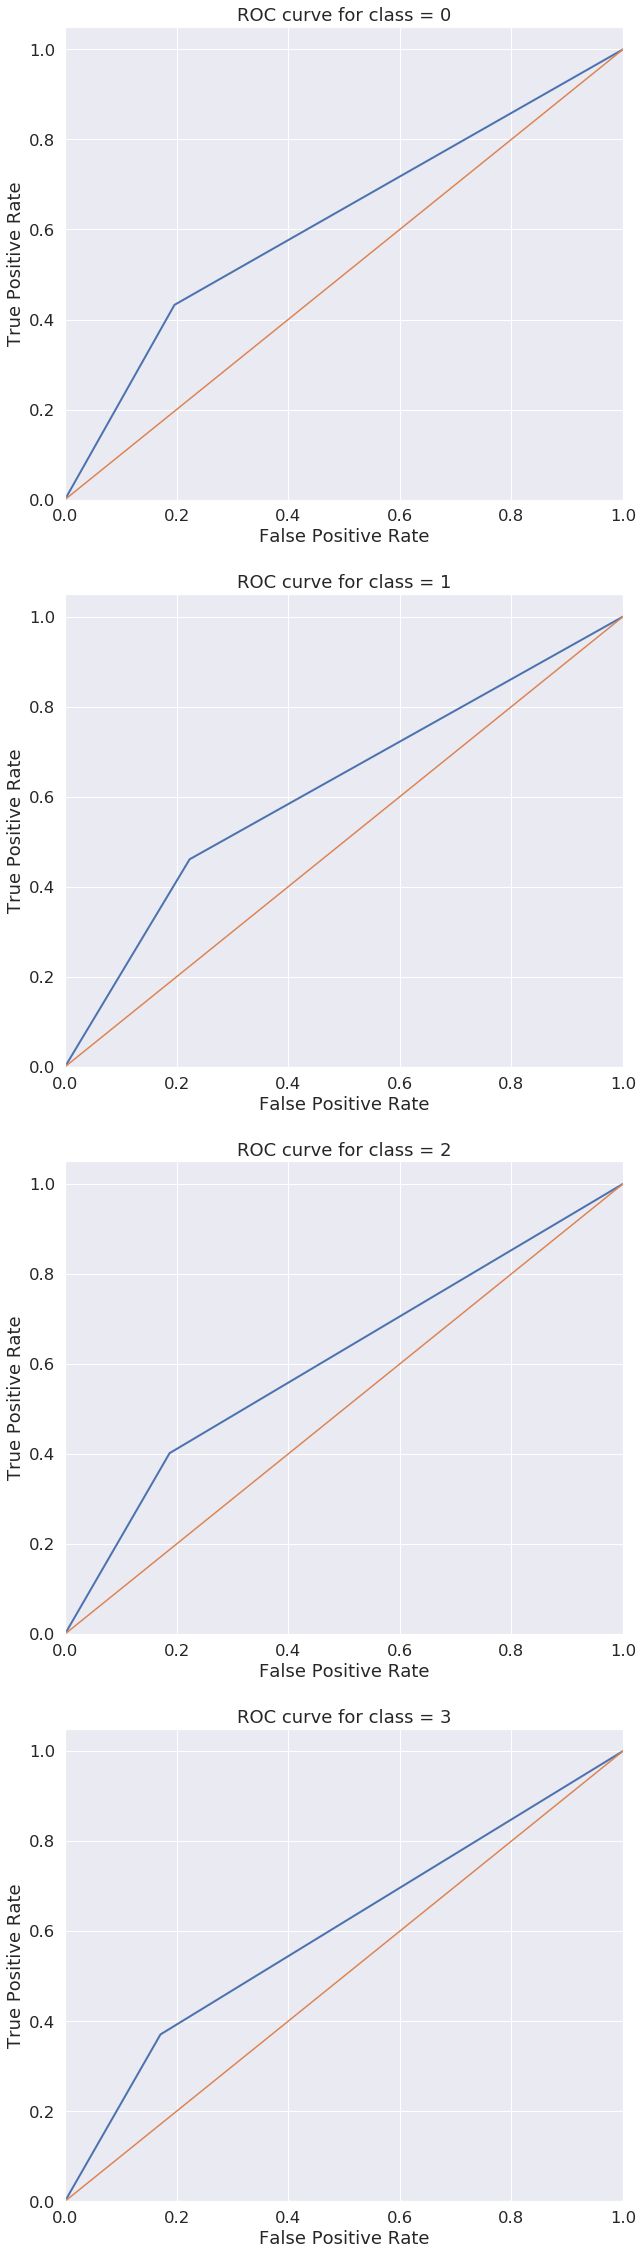

In [10]:
Ytest = np.asarray(Ytest)

sns.set(font_scale=1.5)
sns.set_color_codes("muted")

lw = 2
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 40))
for i in range(4):   
    fpr, tpr, thresholds = roc_curve(Ytest == i, predictions == i, pos_label=1)
    axs[i].plot(fpr, tpr, lw=lw, label='ROC curve ')
    axs[i].plot([0, 1], [0, 1])
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].set_title(f'ROC curve for class = {i}')

plt.show()

## Вывод оптимальных критериев для DecisionTreeClassifier при помощи GridSearch

In [11]:
# Grid search Sci-Kit learn
max_depth = range(2, 30) #максимальная глубина построенного дерева
max_leaf_nodes = range(2, 30) #максимальное кол-во эл-тов в каждом листе
criterion = ['gini', 'entropy'] #критерий разбиения (максимальная энтропия или Неопределенность Джини)

best_score = 0
best_hps = None
for hp1 in max_depth:
    for hp2 in max_leaf_nodes:
        for hp3 in criterion:
            model = DecisionTreeClassifier(criterion=hp3, max_leaf_nodes=hp2, max_depth=hp1)
            model.fit(Xtrain, Ytrain)
            #score = model.score(Xtest, Ytest)
            pred = model.predict(Xtest)
            score = precision_score(pred, Ytest, average='macro')
            if score > best_score:
                best_score = score
                best_hps = {'max_depth': hp1, 'max_leaf_nodes': hp2, 'criterion': hp3}
                
print(best_score)
print(best_hps)

0.4137671481484747
{'max_depth': 6, 'max_leaf_nodes': 26, 'criterion': 'entropy'}


In [12]:
cr = best_hps.get('criterion')
mln = best_hps.get('max_leaf_nodes')
md = best_hps.get('max_depth')
DTC = DecisionTreeClassifier(criterion=cr, max_leaf_nodes=mln, max_depth=md)
DTC.fit(Xtrain, Ytrain)
#predictionsDTC = g_search.predict(Xtest)
predictionsDTC = DTC.predict(Xtest)

## Таблица, содержащая значения F-меры, точность и полноту для DecisionTreeClassifier с критериями, найденными при помощи GridSearch

In [13]:
report = classification_report(Ytest, predictionsDTC)
print(report)

              precision    recall  f1-score   support

           0       0.44      0.32      0.37       941
           1       0.40      0.49      0.44       911
           2       0.39      0.54      0.45       958
           3       0.46      0.31      0.37       974

    accuracy                           0.41      3784
   macro avg       0.42      0.41      0.41      3784
weighted avg       0.42      0.41      0.41      3784



## Кросс-валидация для DecisionTreeClassifier с критериями, найденными при помощи GridSearch

In [14]:
cvs = cross_val_score(DTC, data, labels, cv=8)
print(cvs)

[0.40611814 0.41877637 0.42510549 0.39135021 0.43114407 0.40466102
 0.40572034 0.42266949]


## Вывод оптимальных критериев для DecisionTreeClassifier при помощи Random search

In [15]:
def random_sample(low, high):
    return np.random.randint(low=low, high=high+1)

In [16]:
# Random search
# In random search instead of passing in all hyperparameters' values to try,
# you pass in the distribution of the parameters.
max_depth = (2, 30) #максимальная глубина построенного дерева
max_leaf_nodes = (2, 30) #максимальное кол-во эл-тов в каждом листе
criterion = ['gini', 'entropy'] #критерий разбиения (максимальная энтропия или Неопределенность Джини)

search_iter = 30
best_score = 0
best_hps = None
for i in range(search_iter):
    # Sample parameters
    hp1 = random_sample(*max_depth)
    hp2 = random_sample(*max_leaf_nodes)
    hp3 = np.random.choice(criterion)
    
    model = DecisionTreeClassifier(criterion=hp3, max_leaf_nodes=hp2, max_depth=hp1)
    model.fit(Xtrain, Ytrain)
    #score = model.score(Xtest, Ytest)
    pred = model.predict(Xtest)
    score = precision_score(pred, Ytest, average='macro')
    if score > best_score:
        best_score = score
        best_hps = {'depth': hp1, 'mln': hp2, 'crit': hp3}

print(best_score)
print(best_hps)

0.41216279519841537
{'depth': 26, 'mln': 22, 'crit': 'gini'}


In [17]:
cr = best_hps.get('crit')
mln = best_hps.get('mln')
md = best_hps.get('depth')
DTC = DecisionTreeClassifier(criterion=cr, max_leaf_nodes=mln, max_depth=md)
DTC.fit(Xtrain, Ytrain)
predictionsDTC = DTC.predict(Xtest)

## Таблица, содержащая значения F-меры, точность и полноту для DecisionTreeClassifier с критериями, найденными при помощи Random search

In [18]:
report = classification_report(Ytest, predictionsDTC)
print(report)

              precision    recall  f1-score   support

           0       0.42      0.35      0.38       941
           1       0.40      0.42      0.41       911
           2       0.40      0.53      0.45       958
           3       0.44      0.34      0.38       974

    accuracy                           0.41      3784
   macro avg       0.42      0.41      0.41      3784
weighted avg       0.42      0.41      0.41      3784



## Кросс-валидация для DecisionTreeClassifier с критериями, найденными при помощи Random search

In [19]:
cvs = cross_val_score(DTC, data, labels, cv=8)
print(cvs)

[0.40295359 0.41772152 0.41455696 0.3871308  0.43961864 0.40466102
 0.40995763 0.42161017]


## Вывод оптимальных критериев для KNeighborsClassifier при помощи GridSearch

In [20]:
# Grid search Sci-Kit learn
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = range(2, 60)


best_score = 0
best_hps = None
for hp1 in weights:
    for hp2 in algorithm:
        for hp3 in leaf_size:
            #print(hp1, hp2, hp3)
            model = KNeighborsClassifier(weights=hp1, algorithm=hp2, leaf_size=hp3)
            model.fit(Xtrain, Ytrain)
            #score = model.score(Xtest, Ytest)
            pred = model.predict(Xtest)
            score = precision_score(pred, Ytest, average='macro')
            #print(score)
            if score > best_score:
                best_score = score
                best_hps = {'best_weights': hp1, 'best_algorithm': hp2, 'best_leaf_size': hp3}
                
print(best_score)
print(best_hps)

0.34938965883338696
{'best_weights': 'uniform', 'best_algorithm': 'auto', 'best_leaf_size': 2}


In [21]:
bw = best_hps.get('best_weights')
ba = best_hps.get('best_algorithm')
bls = best_hps.get('best_leaf_size')

model = KNeighborsClassifier(weights=bw, algorithm=ba, leaf_size=bls)
model.fit(Xtrain, Ytrain)
#score = model.score(Xtest, Ytest)
pred = model.predict(Xtest)

## Таблица, содержащая значения F-меры, точность и полноту для KNeighborsClassifier с критериями, найденными при помощи GridSearch

In [22]:
report = classification_report(Ytest, pred)
print(report)

              precision    recall  f1-score   support

           0       0.34      0.45      0.38       941
           1       0.34      0.40      0.37       911
           2       0.36      0.32      0.34       958
           3       0.37      0.23      0.28       974

    accuracy                           0.35      3784
   macro avg       0.35      0.35      0.34      3784
weighted avg       0.35      0.35      0.34      3784



## Кросс-валидация для KNeighborsClassifier с критериями, найденными при помощи GridSearch

In [23]:
cvs = cross_val_score(model, data, labels, cv=8)
print(cvs)

[0.35021097 0.3628692  0.35443038 0.35232068 0.36652542 0.31885593
 0.33474576 0.33474576]


## Вывод оптимальных критериев для KNeighborsClassifier при помощи Random search

In [24]:
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = (2, 60)

search_iter = 30
best_score = 0
best_hps = None
for i in range(search_iter):
    # Sample parameters
    hp1 = np.random.choice(weights)
    hp2 = np.random.choice(algorithm)
    hp3 = random_sample(*leaf_size)
    
    model = KNeighborsClassifier(weights=hp1, algorithm=hp2, leaf_size=hp3)
    model.fit(Xtrain, Ytrain)
    #score = model.score(Xtest, Ytest)
    pred = model.predict(Xtest)
    score = precision_score(pred, Ytest, average='macro')
    if score > best_score:
        best_score = score
        best_hps = {'best_weights': hp1, 'best_algorithm': hp2, 'best_leaf_size': hp3}

print(best_score)
print(best_hps)

0.34938965883338696
{'best_weights': 'uniform', 'best_algorithm': 'ball_tree', 'best_leaf_size': 45}


In [25]:
bw = best_hps.get('best_weights')
ba = best_hps.get('best_algorithm')
bls = best_hps.get('best_leaf_size')

model = KNeighborsClassifier(weights=bw, algorithm=ba, leaf_size=bls)
model.fit(Xtrain, Ytrain)
#score = model.score(Xtest, Ytest)
pred = model.predict(Xtest)

## Таблица, содержащая значения F-меры, точность и полноту для KNeighborsClassifier с критериями, найденными при помощи GridSearch

In [26]:
report = classification_report(Ytest, pred)
print(report)

              precision    recall  f1-score   support

           0       0.34      0.45      0.38       941
           1       0.34      0.40      0.37       911
           2       0.36      0.32      0.34       958
           3       0.37      0.23      0.28       974

    accuracy                           0.35      3784
   macro avg       0.35      0.35      0.34      3784
weighted avg       0.35      0.35      0.34      3784



## Кросс-валидация для KNeighborsClassifier с критериями, найденными при помощи Random search

In [27]:
cvs = cross_val_score(model, data, labels, cv=8)
print(cvs)

[0.35021097 0.3628692  0.35443038 0.35232068 0.36652542 0.31885593
 0.33474576 0.33474576]


## Вывод
    GridSearch достаточно подробный, проходит по всем критериям и выбирает наиболее оптимальный вариант для конкретной их комбинации. Из минусов - это прямой перебор вариантов, т.е. поиск оптимального занимает достаточное кол-во времени
    Random search менее подробный. Он рандомно подбирает комбинации гиперпараметров, но из-за этого даёт довольно хорошую и гибкую скорость поиска. Но так легко упустить более оптимальный вариант и если важно подобрать наиболее оптимальную комбинацию гиперпараметров, то это не наш выбор